Training set distribution: Counter({0: 329, 1: 329, 2: 329, 3: 329, 4: 329})
Best parameters for knn: {'n_neighbors': 1, 'weights': 'uniform'}
Best parameters for svm: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


/home/weimindeqing/miniconda/envs/frankapyenv/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters rf: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Accuracy with Stratified Sampling: 0.97
              precision    recall  f1-score   support

          NC       0.99      1.00      0.99      1244
          ST       0.81      0.88      0.85       134
          DT       0.88      0.91      0.90       259
           P       1.00      0.96      0.98       480
           G       1.00      0.97      0.98       505

    accuracy                           0.97      2622
   macro avg       0.94      0.94      0.94      2622
weighted avg       0.97      0.97      0.97      2622



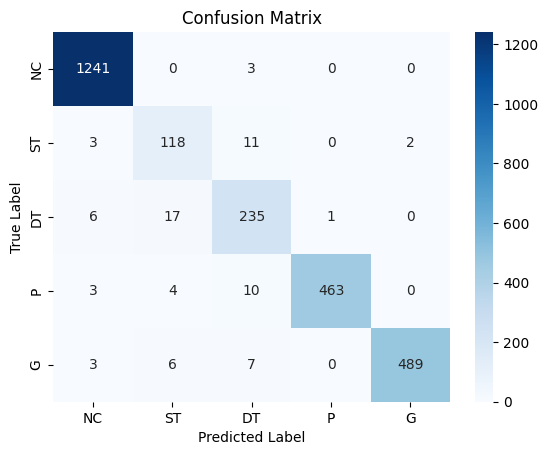

In [3]:
#knn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
# import pywt


# Load data
data_path = '../DATA/labeled_window_dataset.csv'
df = pd.read_csv(data_path)

 # Define columns corresponding to each joint
joint_columns = {
    0: ['e0', 'de0', 'tau_J0', 'tau_ext0'],
    1: ['e1', 'de1', 'tau_J1', 'tau_ext1'],
    2: ['e2', 'de2', 'tau_J2', 'tau_ext2'],
    3: ['e3', 'de3', 'tau_J3', 'tau_ext3'],
    4: ['e4', 'de4', 'tau_J4', 'tau_ext4'],
    5: ['e5', 'de5', 'tau_J5', 'tau_ext5'],
    6: ['e6', 'de6', 'tau_J6', 'tau_ext6'],
}
""" # function to apply DWT and return feature vector
def apply_dwt(data,wavelet = 'db1'):
    coeffs = pywt.wavedec(data,wavelet,level=4)
    features = np.concatenate([np.ravel(c) for c in coeffs])
    return features """


# Initialize feature and label lists
X_list = []
y_list = []

# Group data by 'block_id'
grouped = df.groupby('window_id')


# Process each group
for window_id, group in grouped:
   
    # print(f"group is {group}")
    # Initialize an empty list to hold the features for this block
    window_features = []
    
    # Concatenate data for each joint
    for joint, cols in joint_columns.items():
        # print(f"joint is {joint}")
        # print(f"cols is {cols}")
        joint_data = group.loc[:, cols].values.flatten()  
        # joint_features = apply_dwt(joint_data)
        window_features.extend(joint_data)  
        
    X_list.append(window_features)
    # print(f"X_list is {X_list}")
    y_list.append(group['window_touch_type'].iloc[0])  


# Convert lists to numpy arrays
X = np.array(X_list)
# print(f"X is {X} and length is {len(X)}")
y = np.array(y_list)
# print(f"y is {y} and length is {len(y)}") 
 
# Encode labels
label_classes = { "NC":0,"ST":1, "DT":2, "P":3,"G":4}
# print(f"label_classes is {label_classes}")
label_map = {key:value for key, value in label_classes.items()}
y_encoded = np.array([label_map[label] for label in y])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_resampled,y_resampled = undersampler.fit_resample(X_train,y_train)
print("Training set distribution:", Counter(y_resampled))

# Proceed with your KNN model training
knn = KNeighborsClassifier()

# # Define hyperparameters grid
param_grid_knn = {
    'n_neighbors': list(range(1, 10)),
    'weights': ['uniform', 'distance']
}

# # Initialize GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')



# # Fit GridSearchCV
grid_search_knn.fit(X_resampled, y_resampled)


print(f"Best parameters for knn: {grid_search_knn.best_params_}")

# Get the best parameters
best_knn = grid_search_knn.best_estimator_

svm = SVC()
param_grid_svc = {
    'C':[0.1,1,10,100],
    'gamma':[1,0.1,0.01,0.001,'scale'],
    'kernel':['rbf','linear']
}

grid_search_svm = GridSearchCV(svm,param_grid_svc,cv=5,scoring='accuracy')

grid_search_svm.fit(X_resampled,y_resampled)

print(f"Best parameters for svm: {grid_search_svm.best_params_}")
best_svm = grid_search_svm.best_estimator_


rf = RandomForestClassifier(random_state = 42)
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)


grid_search_rf.fit(X_resampled, y_resampled)


print(f"Best parameters rf: {grid_search_rf.best_params_}")


best_rf = grid_search_rf.best_estimator_





rf_svm_grid_search = VotingClassifier(estimators=[('svm',best_svm),('rf',best_rf),('knn',best_knn)],voting = 'hard')

rf_svm_grid_search.fit(X_resampled,y_resampled)

# Predict and evaluate
y_pred = rf_svm_grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with Stratified Sampling: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=label_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
